# INTERNAL REGRET MATCHING ALGORITHM

## DESCRIPTION

## EXAMPLE GAMES

In [4]:
matching_pennies = [[[1.0,-1.0], [-1.0, 1.0]], 
                    [[-1.0, 1.0], [1.0,-1.0]]]

schere_strein_papier = [[[0,0], [-1, 1], [1, -1]], 
                        [[1,-1], [0, 0], [-1, 1]],
                        [[-1,1], [1, -1], [0, 0]]]

test_game_2 = [[[0,0], [-1, 1], [1, -1]], 
              [[1,-1], [0, 0], [-1, 1]]]

prisoners_dilemma = [[[3,3], [0, 5]],
                     [[5,0], [1, 1]]]

shapley_game = [[[1,0], [0, 1], [0, 0]], 
                [[0,0], [1, 0], [0, 1]],
                [[0,1], [0, 0], [1, 0]]]

# From: No-regret Dynamics and Fictitious Play: https://hal.archives-ouvertes.fr/hal-00713871/document
identical_interest_game = [[[2,2], [1,1],[-4,-4]],
                          [[1,1],[0,0],[-1,-1]],
                          [[-4,-4],[-1,-1],[-2,-2]]]

# From: No-regret Dynamics and Fictitious Play: https://hal.archives-ouvertes.fr/hal-00713871/document
eps = 0.5 

coordination_game = [[[1,1],[1,1],[0,0],[0,0]],
                    [[1-eps,1-eps],[1-eps,1-eps],[-eps,-eps],[-eps,-eps]],
                    [[0,0],[0,0],[1,1],[1,1]], 
                    [[-eps,-eps],[-eps,-eps],[1-eps,1-eps],[1-eps,1-eps]]]



## ALGORITHM IMPLEMENTATION

In [5]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [6]:
#returns the number of actions for a player
def no_of_actions (game, player_no): 
    return np.array(game).shape[player_no]

In [7]:
# returns the utility given a pair of strategies played
def calculate_utility_of_player(game, player, player_0_action, player_1_action): 
    return game[player_0_action][player_1_action][player]

In [8]:
# calculates the replacement payoff at time t of playing replacement_action_k instead of the replaced_action_j played
# this method is only called when replaced_action_j is played
def calculate_utility(game, player, action_player, action_other_player): 
    if player == 0: 
        utility = calculate_utility_of_player(game, player, action_player, action_other_player)
    else: 
        utility = calculate_utility_of_player(game, player, action_other_player, action_player)    
    return utility

In [9]:
def historical_occurences(cumulative_history, player, action_player, action_other_player): 
    if player == 0: 
        occurences = cumulative_history[action_player][action_other_player]
    else: 
        occurences = cumulative_history[action_other_player][action_player]  
    return occurences

In [10]:
# calculates the replacement payoff at time t of playing replacement_action_k instead of the replaced_action_j played
# this method is only called when replaced_action_j is played
def calculate_regret_up_to_time_2(game, time, player, cumulative_history, replaced_action_j, replacement_action_k): 
    no_actions_other_player = no_of_actions(game, (1-player))
    cumulative_regret = 0
    for other_player_action in range(no_actions_other_player):
        replacement_utility = calculate_utility(game, player, replacement_action_k, other_player_action)
        replaced_utility = calculate_utility(game, player, replaced_action_j, other_player_action)
        regret = replacement_utility - replaced_utility
        cumulative_regret += historical_occurences(cumulative_history, player, replaced_action_j, other_player_action) * regret
    return max(1/time * cumulative_regret, 0)

In [11]:
# returns a new probability distribution over a players strategy set given the regret experienced in the past
def calculate_probability_distribution_at_time_2(game, time, player, cumulative_history, my, last_chosen_action_j): 
    no_actions = no_of_actions(game, player)
    probabilities = [(1 / my)* calculate_regret_up_to_time_2(game, time, player, cumulative_history, last_chosen_action_j, action) for action in range(no_actions) if action != last_chosen_action_j]
    last_j_prob = 1 - sum(probabilities)
    probabilities.insert(last_chosen_action_j, last_j_prob)
    return probabilities

In [12]:
def sample_from_distribution(probabilities):
    return random.choices(range(0,len(probabilities)), weights = probabilities)[0]

In [13]:
def euclidean_distance(distribution, new_distribution): 
    p0_dist = np.array(distribution[0])
    p1_dist = np.array(distribution[1])
    
    p0_new_dist = np.array(new_distribution[0])
    p1_new_dist = np.array(new_distribution[1])
    
    p0_distance = (p0_dist - p0_new_dist)**2
    p1_distance = (p1_dist - p1_new_dist)**2
    distance = sum(p0_distance) + sum(p1_distance)
    return math.sqrt(distance)

In [14]:
# my > M^i  * (m^i -1) for all players i
# M^i >= abs(u^i(k, s^-i)- u^i(j, s^-i)) for all j, k (maximum absolute payoff - minimum absolute payoff)
# m^i = number of strategies player i
# return my for each player individually 
def choose_my(game):
    ret = []
    for i in range(2): 
        m_i = no_of_actions(game, i)
        flat_payoffs = np.transpose(game)[i].flatten()
        M_i = np.absolute(np.amax(flat_payoffs) - np.amin(flat_payoffs)) 
        ret.append(M_i * (m_i-1) + 0.01)
    return ret 

In [15]:
# new_mean = old_mean + (new_value - old_mean) / step
# https://math.stackexchange.com/questions/106700/incremental-averaging
def update_mean_distribution(mean_distribution, update_distribution, step): 
    p0_distribution = np.array(mean_distribution[0])  
    p1_distribution = np.array(mean_distribution[1]) 
    new_p0_mean = p0_distribution + (np.array(update_distribution[0]) - p0_distribution)/step
    new_p1_mean = p1_distribution + (np.array(update_distribution[1]) - p1_distribution)/step
    return [new_p0_mean.tolist(), new_p1_mean.tolist()]

In [16]:
# generates a random initial distribution for a game 
def initial_random_distribution(game): 
    no_of_actions_p0 = no_of_actions (game, 0)
    no_of_actions_p1 = no_of_actions (game, 1)
    random_dist_p0 = np.random.random_sample(no_of_actions_p0)
    random_dist_p1 = np.random.random_sample(no_of_actions_p1)
    #normalize 
    random_dist_p0 = random_dist_p0 / sum(random_dist_p0)
    random_dist_p1 = random_dist_p1 / sum(random_dist_p1)
    
    return np.array([random_dist_p0.tolist(), random_dist_p1.tolist()], dtype = object)

## Implementation with cumulative_history of play

In [17]:
# the internal regret matching algorithm converges if the L2 norm change 
# in mean_distribution from step to step + 1 is smaller than epsilon
# or when max_steps has been reached 
# the mean_distribution history is returned

def internal_regret_matching_2(game, max_steps, init_distribution, my, epsilon): 
    distributions = [init_distribution]
    action_p0 = sample_from_distribution(init_distribution[0])
    action_p1 = sample_from_distribution(init_distribution[1])
    cumulative_history = np.zeros(np.array(game).shape[0:2])
    cumulative_history[action_p0][action_p1] = 1
    history = [[action_p0, action_p1]]
    step = 1
    mean_distribution = init_distribution
    while 1: 
        p0_dist = calculate_probability_distribution_at_time_2(game, step, 0, cumulative_history, my[0], action_p0)
        p1_dist = calculate_probability_distribution_at_time_2(game, step, 1, cumulative_history, my[1], action_p1)
        action_p0 = sample_from_distribution(p0_dist)
        action_p1 = sample_from_distribution(p1_dist)
        history.append([action_p0, action_p1])
        cumulative_history[action_p0][action_p1] += 1
        new_distribution = [p0_dist, p1_dist]
        step +=1
        new_mean_distribution = update_mean_distribution(mean_distribution, new_distribution, step)
        distributions.append(new_mean_distribution)
        if euclidean_distance(mean_distribution, new_mean_distribution) <= epsilon and step >=5 or step == max_steps: 
            break
        mean_distribution = new_mean_distribution
    return distributions, history 

## Implementation according to the paper

In [18]:
# calculates the replacement payoff at time t of playing replacement_action_k instead of the replaced_action_j played
# this method is only called when replaced_action_j is played
def calculate_replacement_payoff_at_time(game, time, player, history, replacement_action_k): 
    other_player_strategy = history[time][(1-player)]
    if player == 0: 
        utility = calculate_utility_of_player(game, player, replacement_action_k, other_player_strategy)
    else: 
        utility = calculate_utility_of_player(game, player, other_player_strategy, replacement_action_k)    
    return utility
    

In [19]:
# calculates the cumulative regret of not having played action k instead of action j in the past  
def calculate_regret_up_to_time(game, time, player, history, replaced_action_j, replacement_action_k):
    regret = 0 
    for step in range(time): 
        if history[step][player] == replaced_action_j:
            original_payoff = calculate_utility_of_player(game, player, history[step][0],  history[step][1])
            replacement_payoff = calculate_replacement_payoff_at_time(game, step, player, history, replacement_action_k)
            regret += (replacement_payoff - original_payoff)
    return max(1/time * regret, 0)

In [20]:
# returns a new probability distribution over a players strategy set given the regret experienced in the past
def calculate_probability_distribution_at_time(game, time, player, history, my): 
    last_chosen_action_j = history[(time-1)][player]
    no_actions = no_of_actions(game, player)
    probabilities = [(1 / my)* calculate_regret_up_to_time(game, time, player, history, last_chosen_action_j, action) for action in range(no_actions) if action != last_chosen_action_j]
    last_j_prob = 1 - sum(probabilities)
    probabilities.insert(last_chosen_action_j, last_j_prob)
    return probabilities

In [21]:
# the internal regret matching algorithm converges if the L2 norm change 
# in mean_distribution from step to step + 1 is smaller than epsilon
# or when max_steps has been reached 
# the mean_distribution history is returned

def internal_regret_matching(game, max_steps, init_distribution, my, epsilon): 
    distributions = [init_distribution]
    history_p0 = sample_from_distribution(init_distribution[0])
    history_p1 = sample_from_distribution(init_distribution[1])
    history = [[history_p0,history_p1]]
    step = 1
    mean_distribution = init_distribution
    while 1: 
        p0_dist = calculate_probability_distribution_at_time(game, step, 0, history, my[0])
        p1_dist = calculate_probability_distribution_at_time(game, step, 1, history, my[1])
        new_hist = [sample_from_distribution(p0_dist), sample_from_distribution(p1_dist)]
        history.append(new_hist)
        new_distribution = [p0_dist, p1_dist]
        step +=1
        new_mean_distribution = update_mean_distribution(mean_distribution, new_distribution, step)
        distributions.append(new_mean_distribution)
        if euclidean_distance(mean_distribution, new_mean_distribution) <= epsilon and step >=5 or step == max_steps: 
            break
        mean_distribution = new_mean_distribution
    return distributions
        

## Functions for Plotting

In [22]:
def get_history(player_no, history): 
    return [strategy[player_no] for strategy in history]

In [23]:
# plots a history of the mean distribution for each action of each player

def plot_history(history, game_name): 
    
    hist_p0 = np.transpose(get_history(0, history))
    hist_p1 = np.transpose(get_history(1, history))
    
    fig, ax = plt.subplots()
    
    for action_no, action_history_p0 in enumerate(hist_p0):
        ax.plot(range(len(action_history_p0)), action_history_p0, label ="player:0, action:{}".format(action_no))
    
    for action_no, action_history_p1 in enumerate(hist_p1):
        ax.plot(range(len(action_history_p1)), action_history_p1, label ="player:1, action:{}".format(action_no))
    
    ax.set_title("Internal Regret Matching algorithm with {}".format(game_name))
    ax.set_xlabel('Number of iterations')
    ax.set_ylabel('Averaged strategy probability\nover number of iterations played')
    ax.legend()

In [24]:
def internal_regret_matching_plot(game, game_name, init_distribution, max_steps = 100000, epsilon = 0.00001):
    my = choose_my(game)
    distributions, history = internal_regret_matching_2(game, max_steps, init_distribution, my, epsilon)
    plot_history(distributions, game_name)

# FINDINGS

In [25]:
#internal_regret_matching_plot(prisoners_dilemma, "prisoners_dilemma", initial_random_distribution(prisoners_dilemma))

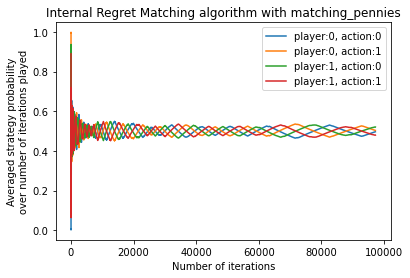

In [26]:
internal_regret_matching_plot(matching_pennies, "matching_pennies", initial_random_distribution(matching_pennies))

In [27]:
#internal_regret_matching_plot(schere_strein_papier, "schere_strein_papier", initial_random_distribution(schere_strein_papier))

In [28]:
#internal_regret_matching_plot(shapley_game, "shapley_game", initial_random_distribution(shapley_game))